TEMUULEN Bulgan
# [EXPLORATION AND ANALYSIS OF PUBLICLY AVAILABLE DATA: SUSPENSION OF PARKING BAYS IN DUBLIN CITY COUNCIL](https://github.com/temulenbd/pbs)

## 1. CREATING THE DATA FRAME AND UNDERSTANDING OF THE DATASET

In [1]:
# Load nessesary libraries.
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from numpy import random
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The file was causing errors in the default read mode. The entire dataset will be analyzed using 'chardet' to determine the encoding type. Afterward, the data will be read using the 'latin1' encoding.

In [2]:
# Detect the encoding of a file
with open('dccparkingbaysuspensionsp20110930-1044.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(-1))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [3]:
# Load a CSV file into a DataFrame
df = pd.read_csv('dccparkingbaysuspensionsp20110930-1044.csv', encoding='latin1')

In [4]:
# Check the DataFrame with head
df.head(2)

,Id,Date,Location of Spaces,No of Spaces,Purpose,Date Suspended,Date Expired,Amount Paid
0,1274,20-Jan-06,Commons Street (IFSC),5,Parking Catering Vehicles,23-Jan-06,23-Jan-06,152.00
1,1275,18-Jan-06,St Stephens Green,3,Collection from KPMG,22-Jun-06,22-Jun-06,114.00


In [5]:
# Check the DataFrame with tail
df.tail(2)

,Id,Date,Location of Spaces,No of Spaces,Purpose,Date Suspended,Date Expired,Amount Paid
2090,4276,14-Jun-11,Fairview Strand,6,Roadhog,26-Jul-11,26-Jul-11,114.00
2091,4277,28-Jun-11,Marlborough Street,1,Shopfitters on Site at Sony Centre,28-Jun-11,01-Jul-11,200.00


In [6]:
# Check the columns and data type
df.dtypes

Id                     int64
Date                  object
Location of Spaces    object
No of Spaces          object
Purpose               object
Date Suspended        object
Date Expired          object
Amount Paid           object
dtype: object

In [7]:
# Check the shape of the DatafFame
df.shape

(2092, 8)

In [8]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092 entries, 0 to 2091
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2092 non-null   int64 
 1   Date                2091 non-null   object
 2   Location of Spaces  2091 non-null   object
 3   No of Spaces        2087 non-null   object
 4   Purpose             2090 non-null   object
 5   Date Suspended      2088 non-null   object
 6   Date Expired        2085 non-null   object
 7   Amount Paid         2092 non-null   object
dtypes: int64(1), object(7)
memory usage: 130.9+ KB


##   2. DATA CLEANING AND MANIPULATION

### **2.1. Renaming columns, adding new columns, and re-arranging them.**

The "ID" column will be removed, and number indexing will be used for data manipulation and mapping. Additionally, two new columns will be added.

In [9]:
# Drop the column
df.drop(labels='Id', axis=1, inplace=True)

# Add columns
df['str_class'] = ''
df['duration'] = ''

Rename the data frame's columns with all lower letters and underscores instead of spaces and case letters, and then rearrange them.

In [10]:
# Rename columns in the DataFrame to lowercase and replace spaces with underscores for better consistency and usability
df.rename(columns={col: col.replace(' ', '_').lower() for col in df.columns}, inplace=True)

# Reorder the columns in the DataFrame based on the specified index positions
df = df.iloc[:, [1,7,3,0,4,5,8,2,6]]
df.head(2)

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
0,Commons Street (IFSC),,Parking Catering Vehicles,20-Jan-06,23-Jan-06,23-Jan-06,,5,152.00
1,St Stephens Green,,Collection from KPMG,18-Jan-06,22-Jun-06,22-Jun-06,,3,114.00


### **2.2. Data type conversion of each column**

#### `location_of_spaces`

A custom function will be created for the data type conversion of the "location_of_spaces" column, which will be applied using the 'apply()' function. Subsequently, all the values in the column will be converted to strings, with None values replaced by empty strings.

In [11]:
# Custom function to convert a value to a string, handling the case where the value is None
def convert_to_str(val):         
    if val == None:
        return ''
    else:
        return str(val)

# Applying the custom function to the 'location_of_spaces' column
df['location_of_spaces'] = df['location_of_spaces'].apply(convert_to_str)
df['location_of_spaces'].dtype

dtype('O')

#### `purpose`

The same approach will be applied to the "purpose" column, converting all values to strings, while replacing None values with empty strings.

In [12]:
# Applying the custom function to the 'purpose' column
df['purpose'] = df['purpose'].apply(convert_to_str)

df['purpose'].dtype

dtype('O')

#### `date` `date_suspended` `date_expired`

The data types of the 'date', 'date_suspended', and 'date_expired' columns will be converted from Object to DateTime format.

In [13]:
# Convert the 'date', 'date_suspended', and 'date_expired' columns to datetime objects
df['date'] = pd.to_datetime(df['date'])
df['date_suspended'] = pd.to_datetime(df['date_suspended'])
df['date_expired'] = pd.to_datetime(df['date_expired'])

df.dtypes

location_of_spaces            object
str_class                     object
purpose                       object
date                  datetime64[ns]
date_suspended        datetime64[ns]
date_expired          datetime64[ns]
duration                      object
no_of_spaces                  object
amount_paid                   object
dtype: object

#### `no_of_spaces`

The unique values in the 'no_of_space's column will be checked first. Any non-numeric values will be replaced with either Numeric or None, depending on the type.

In [14]:
# Calculate the frequency of each unique value in the 'no_of_spaces' column
df['no_of_spaces'].value_counts()

no_of_spaces
4                                           513
2                                           314
3                                           264
6                                           258
5                                           162
8                                            99
10                                           91
7                                            84
1                                            79
12                                           44
20                                           21
15                                           21
9                                            19
13                                           16
All                                          14
16                                           13
18                                            9
25                                            7
14                                            7
22                                            6
40                         

In [15]:
df['no_of_spaces'].replace(to_replace={'15 (plus 10 parking spaces - Coach Area)':25,
                                       '13 Bays':13,
                                       'An Additional 2':3,
                                       '10 (Enitre Length)':10,
                                       '15 (All)':15,
                                       'All spaces':np.nan,
                                       'All':np.nan}, inplace=True)

df['no_of_spaces'] = pd.to_numeric(df['no_of_spaces'])
df['no_of_spaces'].dtype

dtype('float64')

#### `amount_paid`

A custom function will be created for converting the data type of the "amount_paid" column, which will be applied using the 'apply()' function. All values in the column will be converted to Float, while None values will be replaced with NaN.

In [16]:
# Custom function to convert a value to a float, handling commas and converting zeros to NaN
def convert_to_float(val):     
    new_val = val.replace(',','')
    if float(new_val) == 0:
        return float('Nan')
    else:
        return float(new_val)

# Apply the custom function to the 'amount_paid' column
df['amount_paid'] = df['amount_paid'].apply(convert_to_float)
df['amount_paid'].dtype

dtype('float64')

### 2.3. Accessing, modifying, and handling the values.

I am checking the total missing values of the DataFrame and missing values in each column.

In [17]:
# Calculate the total number of missing values in the DataFrame
df.isnull().sum().sum()

379

In [18]:
# Calculate the number of missing values in each column of the DataFrame
df.isnull().sum()

location_of_spaces      0
str_class               0
purpose                 0
date                    1
date_suspended          4
date_expired            7
duration                0
no_of_spaces           20
amount_paid           347
dtype: int64

Duplicates are being checked and removed from the DataFrame.

In [19]:
# Identify and display duplicate rows in the DataFrame
df[df.duplicated()]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
604,St. Ignatius Road,,Delivery,2006-12-21,2007-01-03,2007-01-05,,NaN,556.6
1574,Parnell Square East,,Filming in Rotunda (Pillar Room),2009-06-08,2009-06-11,2009-06-11,,8.0,400.0
1670,Lennox Street,,Filming,2009-11-12,2009-11-18,2009-11-18,,6.0,246.0


In [20]:
# Count the number of non-null values in each column of the DataFrame
df.count()

location_of_spaces    2092
str_class             2092
purpose               2092
date                  2091
date_suspended        2088
date_expired          2085
duration              2092
no_of_spaces          2072
amount_paid           1745
dtype: int64

In [21]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()
df.count()

location_of_spaces    2089
str_class             2089
purpose               2089
date                  2088
date_suspended        2085
date_expired          2082
duration              2089
no_of_spaces          2070
amount_paid           1742
dtype: int64

After removing three rows from the DataFrame, the index order will be reset to ensure continuity.

In [22]:
# Reset the index of the DataFrame, adding a new default index
df = df.reset_index()
df = df.iloc[:, 1:]

#### `location_of_spaces`

The 'location_of_spaces' column contains many errors due to manual input by random users, which leads to linguistic and spelling issues. Using these erroneous values directly would be challenging, and simply removing them is not a viable option. To address this, I plan to use a more reliable source: a CSV file containing standard street names, found in the Transport section of the government's <data.gov.ie> website. This file includes columns that categorize road and street names by street class, area code, area type, and sub-zone. I will use this dataset to replace the erroneous values with standardized street names.

In [23]:
# Opening the CSV file in binary mode and detecting the character encoding
with open('DCC_DublincityRoadsandStreets.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(-1))
    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.7295679673408915, 'language': ''}


In [24]:
# Reading the CSV file containing Dublin city roads and streets data, using Latin-1 encoding
df_standard_names = pd.read_csv('DCC_DublincityRoadsandStreets.csv', encoding='latin1')

df_standard_names.head(3)

,street_name,street_class_code,new_area_code,surface_type_code,Subarea,Subarea EA,line_length,route_no,year_built,os_sheets,road_start,road_finish,Irish
0,ABBEY PARK,6.0,3,2.0,14,14,172.0,NaN,NaN,319805.0,KILLESTER AVE.,NaN,Páirc na Mainistreach
1,ABBEY STREET LOWER,3.0,1,1.0,15,15,315.0,NaN,NaN,326401.0,O'CONNELL ST.,BERESFORD PLACE,Sráid na Mainistreach íocht
2,ABBEY STREET MIDDLE,3.0,1,1.0,12,12,251.0,NaN,NaN,326305.0,LR. LIFFEY STREET,O'CONNELL STREET,Sráid Mheadhan na Mainistreach


In [25]:
# Checking the shape (number of rows and columns) of the DataFrame
df_standard_names.shape

(4771, 13)

The `for loop` will be used to scan all values in the "street_name" column of the "df_standard_names" DataFrame, as well as the "location_of_spaces" column in the main DataFrame. Afterward, each value will be compared, and user inputs will be replaced with standardized street names. The process will involve iterating forwards and backwards between the two DataFrames to ensure no common values are left unchanged. If a match is found and replaced in the primary DataFrame, it will be possible to differentiate lowercase values from those that remain unaffected.

In [26]:
# Iterate over each row in df_standard_names to find matching street names in df
for index1 in range(len(df_standard_names.index)):
    standard_name = df_standard_names.loc[index1, 'street_name'].lower()
    for index2 in range(len(df.index)):
        name_to_change = df.loc[index2, 'location_of_spaces'].lower()
        if standard_name in name_to_change:
            df.loc[index2, 'location_of_spaces'] = standard_name

In [27]:
# Iterate over each row in df to update 'location_of_spaces' if it matches a street name in df_standard_names
for index1 in range(len(df.index)):
    name_to_change = df.loc[index1, 'location_of_spaces'].lower()
    for index2 in range(len(df.index)):
        standard_name = df_standard_names.loc[index2, 'street_name'].lower()
        if name_to_change in standard_name:
            df.loc[index1, 'location_of_spaces'] = name_to_change

At this point, it is possible to check the remaining values. If a value begins with a capital letter or a number, it indicates that the value is faulty.

In [28]:
# Identify and print values in 'location_of_spaces' column that start with an uppercase letter or a digit
unique_val = df['location_of_spaces'].value_counts()

for faulty_value in unique_val.index:
    if faulty_value[0].isupper():
        print(faulty_value)
    elif faulty_value[0].isdigit() :
        print(faulty_value)

St. Stephens Green North
Stephens Green North
Stephens Green
Stephens Green East
Northwall Quay
North Great Georges Street
St. Stephens Green
Prince's Street
Princes Street
South Anne Street
Upper Mount Street
Sir John Rogersons Quay
Merrion Square
St. Stephens Green West
Northwall Quay, Dublin 1
St. Stephens Green East
Lower Mount Street
St Stephens Green
Sherrard Street
Swifts Row
Princes Street South
St. Stephens Green South
Upper Hatch Street
Kenilworth Square
Ship Street
Serpintine Avenue
Baggot Street (Outside Bank of Ireland)
South Richmond Street
Upper Drumcondra Road
St. Annes Road North
Drumcondra Road (Outside Quinns Pub)
St. Stephen's Green North
William Street South
Parnell Square
Stephens Green (Outside Dandelions)
South Annes Street
St Augustine Street
Pleasant Street
Palmerstown Road
Lower Baggot Street
St Stephens Green South
Stephens Green North (Outside Topshop)
Fitzwilliam Square (East Gate)
St. Stevens Green North
Stephens Green (Near Shelbourne Hotel)
John Rogerso

In [29]:
# Show the length of unique values in the 'location_of_spaces' column
len(unique_val.index)

655

A total of 655 values contained spelling errors or non-standard names. Various methods, including Sequence Matcher's string prediction, FuzzyWuzzy's processing, for loops, while loops, and regular expressions, were attempted to replace the incorrect values with standard terms, but all attempts were unsuccessful. It was determined that in cases where user input errors occur, manual checking is necessary. To address this, two list variables were created: one containing partial strings of the faulty cells and another with common names. By using a 'for loop', all mismatches were identified and replaced.

In [30]:
# Create a list containing parts of the string that correspond to faulty values
to_replace = ['stephens green', 'northwall', 'north great', 'prince\'s', 'prince', 'south anne', 'mount', 'rogers', 'merrion', 'sherrard', 'swift', 'hatch', 'kenilworth', 'drumcondra', 
              'ship s', 'stephen', 'baggot', 'serpin', 'william', 'anne', 'parnell', 'richmond', 'mayor', 'mercer', 'glouce', 'sandwith', 'pleasant', 'inns', 'palmerst', 'steven', 'joseph', 'ville st', 
              'kevin', 'townsend', 'francis', 'rahen', 'herber', 'stphens', 'alphonsus', 'guild', 'wolfe', 'marys', 'fishamble', 'james', 'charlotte', 'stephnes', 'frederick', 'castle', 'lombard', 
              'sussex', 'north wall', 'emmet', 'benedict', 'moleswoth', 'fitzwil', 'connoly', 'nassau', 'blackhal', 'albany', 'serpent', 'ann s', 'dorset', 'custom hou', 'artane', 'ignatius', 
              'kings inn', 'exchequer', 'grangegorman', 'tham', 'claredon', 'amien', 'dillion', 'mary', 'johns r', 'nass', 'george','bello', 'king','ietta', 'vernon', 'john', 'fred', 'parnel', 'gros', 'monta', 
              'dominic', 'werburg', 'inchic', 'sher', 'gloucester', 'whit', 'augustine', 'peter', 'rubi', 'patrick', 'donnybrook', 'earl', 'leeson','inn', 'sim', 'foster', 'ratdown', 'kenilworth', 
              'eccles', 'vincent', 'glen', 'liffey', 'fa', 'donovan','glouc', 'hendrick', 'win', 'liffey', 'ken']

len(to_replace)

114

In [31]:
# Create a list of standard names
replacement = ['saint stephens green east', 'north wall quay', 'north great george\'s street', 'prince\'s street', 'prince\'s street', 'anne street south', 'mount street crescent', 'sir john rogerson\'s quay', 'merrion square east', 'sherrard street lower', 'swift\'s row', 
               'hatch street upper', 'kenilworth square east', 'drumcondra road', 'ship street great', 'saint stephens green east', 'baggot street lower', 'serpentine avenue', 'william street north', 'saint anne\'s road', 'parnell street', 'richmond street south', 'mayor street lower', 
               'mercer street lower', 'gloucester street south', 'sandwith street lower','pleasants street', 'kings inns street','palmerston road', 'saint stephens green east','saint joseph\'s avenue', 'grenville street', 'kevin street lower', 'townsend street', 'francis street', 'raheny road', 
               'herbert cottages', 'saint stephens green east', 'saint alphonsus road', 'guild street', 'wolfe tone street', 'saint mary\'s avenue north', 'fishamble street', 'james\'s street', 'charlotte way', 'saint stephens green east', 'frederick street south', 'castle street', 'lombard street east', 
               'sussex road','north wall quay', 'emmet road', 'saint benedict\'s gardens', 'molesworth street', 'fitzwilliam place', 'amiens street', 'nassau street', 'blackhall place', 'albany road', 'serpentine avenue', 'anne street north', 'dorset street lower', 'custom house quay', 
               'artane castle service road', 'saint ignatius road', 'kings inns street', 'exchequer street', 'grangegorman lower', 'chatham street', 'johnson\'s court', 'amiens street', 'john dillon street', 'saint mary\'s avenue north', 'saint john\'s road west', 'nassau street', 'north great george\'s street', 
               'portobello', 'kings inns street', 'henrietta street', 'vernon avenue', 'john\'s lane west', 'frederick court', 'parnell street', 'grosvenor road', 'montague street', 'dominick street lower', 'werburgh street', 'inchicore road', 'sheriff street upper', 'gloucester street south', 'whitefriar place',
               'saint augustine street', 'peter street', 'saint stephens green', 'saint patrick\'s close', 'donnybrook road', 'earlsfort terrace', 'leeson street upper', 'inns quay', 'simmonscourt avenue', 'foster place', 'rathdown road', 'kenilworth square east', 'eccles street', 'saint vincent street south', 
               'glengarriff parade', 'liffey street west', 'faussagh avenue', 'donovan lane', 'gloucester street south', 'hendrick street', 'windsor terrace', 'liffey bridge', 'kenilworth lane']

len(replacement)

114

In [32]:
# Iterate over each row in the DataFrame and replace specific values in 'location_of_spaces' if they start with a digit or uppercase letter
for index in range(len(df.index)):
    str_name = df.loc[index, 'location_of_spaces']
    if str_name[0].isnumeric() or str_name[0].isupper():
        faulty_val = str_name.lower()
        for num in range(len(to_replace)):
            if to_replace[num] in faulty_val:
                df.loc[index, 'location_of_spaces'] = replacement[num]

In [33]:
# Identify and print values in 'location_of_spaces' column that start with an uppercase letter or a digit
unique_val = df['location_of_spaces'].value_counts()
for faulty_value in unique_val.index:
    if faulty_value[0].isupper():
        print(faulty_value)
    elif faulty_value[0].isdigit() :
        print(faulty_value)

No output to show, indicating that the desired result has been achieved.

In [34]:
# Count the number of missing values in the 'location_of_spaces' column
df['location_of_spaces'].isnull().sum()

0

In [35]:
# Get the data type of the 'location_of_spaces' column
df['location_of_spaces'].dtype

dtype('O')

In [36]:
# Iterate over unique values in the 'location_of_spaces' column and print each value
unique_val = df['location_of_spaces'].value_counts()
for faulty_value in unique_val.index:
    print(faulty_value)

saint stephens green east
north wall quay
townsend street
merrion road
gloucester street
temple street
sandymount green
mount street crescent
fishamble street
merrion square east
nassau street
clonmel street
prince's street
parnell street
eccles street
shelbourne road
inchicore road
molesworth street
castle street
hatch street
north great george's street
fitzwilliam place
ballsbridge avenue
wolfe tone street
haddington road
camden row
baggot street lower
henrietta street
john's lane west
francis street
saint anne's road
dame court
fitzwilliam street
smithfield
deverell place
lansdowne road
merrion square west
cabra road
barrow street
merrion square south
cook street
north circular road
burlington road
lotts
inns quay
serpentine avenue
haymarket
pembroke street
wilton terrace
fitzwilliam square east
drumcondra road lower
hatch street upper
earlsfort terrace
capel street
palace street
strand street
charlemont
camden street
clarendon row
d'olier street
jervis street
pembroke road
adelaide

#### `str_class`

The "location_of_spaces" column now contains the standardized street names. However, handling these values without generalization would be challenging. To address this, the 'for loop' will be run again to insert the corresponding values into the "str_class" column. The "street_class_code" column from the "df_standard_names" DataFrame will be used for classification.

In [37]:
# Check the DataFrame
df.head()

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
0,commons street,,Parking Catering Vehicles,2006-01-20,2006-01-23,2006-01-23,,5.0,152.0
1,saint stephens green east,,Collection from KPMG,2006-01-18,2006-06-22,2006-06-22,,3.0,114.0
2,saint stephens green east,,To facilate filiming,2006-01-05,2006-01-09,2006-01-09,,4.0,152.0
3,saint stephens green east,,Road Caster,2006-01-05,2006-01-09,2006-01-09,,4.0,152.0
4,molesworth street,,To facilate Filiming,2006-01-05,2006-01-09,2006-01-09,,12.0,152.0


In [38]:
# Iterate over each row in df and compare 'location_of_spaces' with 'street_name' in df_standard_names
for index1 in range(len(df.index)):
    road_street_name1 = df.loc[index1, 'location_of_spaces'].lower()
    for index2 in range(len(df_standard_names.index)):
        road_street_name2 = df_standard_names.loc[index2, 'street_name'].lower()
        if road_street_name1 in road_street_name2:
            df.loc[index1, 'str_class'] = df_standard_names.loc[index2, 'street_class_code']

In [39]:
# Count the occurrences of each street class code in the 'str_class' column
df['str_class'].value_counts()

str_class
4.0    710
2.0    405
1.0    357
6.0    319
5.0    131
3.0    114
7.0     44
         5
1.5      4
Name: count, dtype: int64

Five rows have no area codes. Check out these rows.

In [40]:
# Filter rows where the 'str_class' column is empty
df.loc[(df['str_class'] == '')]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
1003,o/s Fitzwilliam Hotel St Stephens Green,,Roadhog,2007-11-28,2007-11-29,2007-11-29,,4.0,164.0
1004,o/s Fitzwilliam Hotel St Stephens Green,,Roadhog,2007-11-29,2007-12-19,2007-12-19,,4.0,164.0
1698,outside John Schutte Associates & Teatime Express,,use of removal van,2009-12-15,2010-01-06,2010-01-06,,1.0,50.0
1709,27 Upper Mount Street,,office move,2010-01-22,2010-01-29,2010-01-29,,1.0,50.0
1763,"outside Anglo Irish Bank, St. Stephens Green",,broadcast on 2FM,2010-05-06,2010-05-10,2010-05-10,,3.0,150.0


The non-standard values in the "location_of_spaces" column were missed by the 'for loop' due to the strings starting with a lowercase letter and a space. To correct this, the "to_replace" method from pandas will be used to replace the values. Afterward, the loop for 'str_class' values will be run again.

In [41]:
# Replace specific values in the 'location_of_spaces' column with predefined replacements
df = df.replace(to_replace={'location_of_spaces':{
    'o/s Fitzwilliam Hotel St Stephens Green': 'saint stephens green east',
    'outside John Schutte Associates & Teatime Express': 'cecilia street',
    ' 27 Upper Mount Street': 'mount street upper',
    'outside Anglo Irish Bank, St. Stephens Green': 'saint stephens green east'
}})

In [42]:
# Iterate over each row in df and compare 'location_of_spaces' with 'street_name' in df_standard_names
for index1 in range(len(df.index)):
    road_street_name1 = df.loc[index1, 'location_of_spaces'].lower()
    for index2 in range(len(df_standard_names.index)):
        road_street_name2 = df_standard_names.loc[index2, 'street_name'].lower()
        if road_street_name1 in road_street_name2:
            df.loc[index1, 'str_class'] = df_standard_names.loc[index2, 'street_class_code']

In [43]:
# Count the occurrences of each street class code in the 'str_class' column
df['str_class'].value_counts()

str_class
4.0    711
2.0    405
1.0    360
6.0    319
5.0    132
3.0    114
7.0     44
1.5      4
Name: count, dtype: int64

There are four unique values with a street class code of 1.5. Logically, a half-number classification is not valid, indicating an error or incorrect input. These values will be replaced with the mode value, as the column is based on ordinal data.

In [44]:
# Filter rows where the 'str_class' column equals 1.5
df.loc[(df['str_class'] == 1.5)]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
695,dame street,1.5,Roadhog,2007-03-22,2007-03-31,2007-03-31,,4.0,152.0
722,dame street,1.5,Site Compound,2007-04-24,2007-05-01,2007-06-20,,4.0,NaN
801,clanbrassil street,1.5,Filming,2007-06-08,2007-06-12,2007-06-12,,4.0,121.6
1102,dame street,1.5,FM104 Roadhog,2008-03-13,2008-04-06,2008-04-06,,4.0,164.0


In [45]:
# Calculate the mode (most common value) of the 'str_class' column
df['str_class'].mode()

0    4.0
Name: str_class, dtype: object

In [46]:
# Replace all occurrences of 1.5 with 4 in the 'str_class' column, modifying the DataFrame in place
df['str_class'].replace(1.5, 4, inplace=True)

### 2.4. Missing values of the dataframe.

#### `amount_paid`

In this section, the value-handling process will continue, with a focus on addressing missing values for each column. For the "amount_paid" column, we previously converted 0 values to None and changed object values to float in cell 16. Now, the next step will be to replace the None values with 0 and logically investigate the reason behind the 0 payments.

In [47]:
# Replace missing values (NaN or None) in the 'amount_paid' column with 0 and check the count of null values
df.replace({'amount_paid': {np.nan:0, None:0}}, inplace=True)

df['amount_paid'].isnull().sum()

0

In [48]:
# Filter rows where 'amount_paid' is 0 and count occurrences of each unique 'purpose'
nopay = df.loc[(df['amount_paid'] == 0)]
nopay_purpose = nopay['purpose'].value_counts()

# Print each unique purpose for rows with 'amount_paid' equal to 0
for each_purpose in nopay_purpose.index:
    print(each_purpose)

Blood Donation Clinic
Site Compound
Outside Broadcast
Marshell's Office for the Exhibition
Blood Donations
Filming
Filiming Vehicles
Broadcast
Completion of Contract to Reinforce River Wall
blood donation clinic @ Mater Hospital
To locate the Marshall who will be available to exhibitors
Adidas Dublin City Marathon
Blood donation clinic
St. Patrick's Festival
Fundraising
Charity Drive (Roadcaster)
Mobile Unit (Irish Blood Tansfusion Service)
Construction of Granite Footpath on Drumcondra Rd
Marshell's Office For Exhibition
To Facilate Filiming
Mars Hell's Office for the Exhibition
Dublin City Marathon
blood donation clinic @ Eirgrid
To facilitate Crane
Maintenance of bridge lights
Unloading & loading of bikes for Bloomsday Charity bicycle rally
restoration work
Office Move
blood donation clinic
Mobile Information Unit
LUAS Extension Works
Parade Float
Office Relocation
Loading and unloading equipment into Merrion Square Park
Parking of Parade Floats and access
Portakabin for Festival eq

Rows with 0 payments will be dropped because most activities are public-related and government-dependent, such as blood donations, marathons, fundraising, exhibitions, festivals, ceremonies, and the restoration of state-owned buildings. In other words, these activities, which are organized by the government, are unlikely to receive payment.

In [49]:
# Filter out rows where 'amount_paid' is not equal to 0
df = df.loc[df['amount_paid'] != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1742 entries, 0 to 2088
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   location_of_spaces  1742 non-null   object        
 1   str_class           1742 non-null   float64       
 2   purpose             1742 non-null   object        
 3   date                1742 non-null   datetime64[ns]
 4   date_suspended      1739 non-null   datetime64[ns]
 5   date_expired        1737 non-null   datetime64[ns]
 6   duration            1742 non-null   object        
 7   no_of_spaces        1739 non-null   float64       
 8   amount_paid         1742 non-null   float64       
dtypes: datetime64[ns](3), float64(3), object(3)
memory usage: 136.1+ KB


Any negative payment values will be corrected, as payments cannot be negative. These values will be replaced with the appropriate value, ensuring they reflect valid payment amounts.

In [50]:
# Filter rows where 'amount_paid' is less than 0
df.loc[df['amount_paid'] < 0]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
1471,drumcondra road,1.0,FM104 Roadhog,2009-01-27,2009-02-17,2009-02-17,,4.0,-76.0


In [51]:
# Replace -76 with 76 in the 'amount_paid' column, modifying the DataFrame in place
df.replace(to_replace={'amount_paid' : {-76 : 76}}, inplace=True)

In [52]:
# Reset the index of the DataFrame and remove the old index column
df = df.reset_index()
df = df.iloc[:, 1:]

#### `duration`

Based on information from the official government website, the duration of parking bay suspensions is calculated in days, and charges differ by location zone. The "duration" column can be derived by calculating the time period between the "date_expired" and "date_suspended" columns. These two date columns will be used to compute the total number of days each suspension lasts.
(Source: Dublin City Council – Parking Suspensions)

In [53]:
# Calculate duration for each row based on 'date_expired' and 'date_suspended' columns
for x in range(len(df.index)):
    if df.loc[x, 'date_expired'] == 0:
        df.loc[x, 'duration'] = None
    elif df.loc[x, 'date_suspended'] == 0:
        df.loc[x, 'duration'] = None
    else:
        duration = df.loc[x, 'date_expired'] - df.loc[x, 'date_suspended']
        df.loc[x, 'duration'] = duration.days + 1

In [54]:
# Count the number of missing values in the 'duration' column
df['duration'].isnull().sum()

5

The column contains a few None values, and the corresponding full rows with these missing entries are to be examined.

In [55]:
# Filter rows where 'duration' column contains missing values (NaNs)
none_value = df[df['duration'].isnull() == True]

none_value

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
155,bath avenue,6.0,Permanent removal of parking space,2006-05-17,NaT,NaT,NaN,1.0,1400.0
203,argyle road,6.0,Permanent removal of parking space,2026-06-07,NaT,NaT,NaN,1.0,1400.0
339,derrynane gardens,6.0,Permanent removal of parking space,2006-08-31,NaT,NaT,NaN,1.0,2100.0
389,vernon avenue,2.0,Permanent Removal of Parking Space,2006-09-26,2006-10-26,NaT,NaN,1.0,2100.0
1430,anglesea road,2.0,Roadhog,2009-12-01,2009-12-19,NaT,NaN,4.0,164.0


Rows 155 and 203 show a suspension payment of 1400, while the "date suspended" and "date expired" columns are blank. However, the "date" column provides a starting point. In such cases, the duration can be estimated by dividing the total paid amount by the average current suspension rate per day.

Since the "date suspended" and "date expired" fields may be needed later, the value in the "date" column will be assigned as the suspension date. The expiration date can then be calculated by adding the estimated duration (in days) to this suspension date.

In [56]:
# Calculate the approximate duration for parking removal based on mean daily payment
amount_paid1 = df.loc[155, 'amount_paid']
mean_payment_daily = (50+41+27+19+12.5)/5
print('Daily payment mean is:', mean_payment_daily)
duration_1400 = int(amount_paid1/mean_payment_daily)
print('Approximate duration of the days for parking removal was:', duration_1400)

df.loc[[155, 203], 'duration'] = duration_1400
df.loc[155, 'date_suspended'] = df.loc[155, 'date']
df.loc[155, 'date_expired'] = pd.to_datetime(df.loc[155, 'date']) + timedelta(days=duration_1400)
df.loc[203, 'date_suspended'] = df.loc[203, 'date']
df.loc[203, 'date_expired'] = pd.to_datetime(df.loc[203, 'date']) + timedelta(days=duration_1400)

Daily payment mean is: 29.9
Approximate duration of the days for parking removal was: 46


Rows 339 and 389 follow the same pattern, with a payment of 2100 for each suspension and missing values in both the "expiration date" and "suspension date" columns. The same estimation method will be applied to calculate the duration and infer the missing dates accordingly.

In [57]:
# Calculate the approximate duration for parking removal based on mean daily payment
amount_paid2 = 2100
mean_payment_daily = (50+41+27+19+12.5)/5
print('Daily payment mean is:', mean_payment_daily)
duration_2100 = int(amount_paid2/mean_payment_daily)
print('Approximate duration of the days for parking removal was:', duration_2100)

df.loc[[339, 389], 'duration'] = duration_2100
df.loc[339, 'date_suspended'] = df.loc[339, 'date']
df.loc[339, 'date_expired'] = pd.to_datetime(df.loc[339, 'date']) + timedelta(days=duration_2100)
df.loc[389, 'date_expired'] = pd.to_datetime(df.loc[389, 'date_suspended']) + timedelta(days=duration_2100)

Daily payment mean is: 29.9
Approximate duration of the days for parking removal was: 70


Identical method for row 1430.

In [58]:
# Calculate the approximate duration for parking removal based on mean daily payment
amount_paid3 = 164
mean_payment_daily = (50+41+27+19+12.5)/5
print('Daily payment mean is:', mean_payment_daily)
duration_164 = int(amount_paid3/mean_payment_daily)
print('Approximate duration of the days for roadhog was:', duration_164)

df.loc[1430, 'duration'] = duration_164
df.loc[1430, 'date_expired'] = pd.to_datetime(df.loc[1430, 'date_suspended']) + timedelta(days=duration_164)

Daily payment mean is: 29.9
Approximate duration of the days for roadhog was: 5


With all missing data now addressed, a quick review of the column can be conducted to ensure consistency and correctness.

In [59]:
# Convert the 'duration' column to numeric data type
df['duration'] = pd.to_numeric(df['duration'])
df['duration'].dtype

dtype('int64')

In [60]:
# Count the occurrences of each duration value in the 'duration' column
df['duration'].value_counts()

duration
 1        1283
 2         157
 5          90
 3          71
 4          32
 7          19
 6          13
 8           7
 9           6
 26          5
 22          5
 46          3
 11          3
 60          3
 21          3
 30          2
 33          2
 10          2
 15          2
 70          2
 19          2
 55          2
 32          2
 31          2
 10959       1
 52          1
 367         1
 3288        1
-9           1
 29          1
 24          1
 25          1
 45          1
 61          1
 150         1
 50          1
 27          1
 40          1
 12          1
 112         1
-58          1
 123         1
-1092        1
 13          1
 62          1
 370         1
-29          1
 486         1
Name: count, dtype: int64

Some entries seem to contain unusually high numerical values. The next step is to examine the data points with the largest values to identify and correct potential input errors.

In [61]:
# Filter rows where 'duration' is greater than 50
df.loc[(df['duration'] > 50)]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
6,townsend street,2.0,To allow access to loading Bay,2006-01-05,2005-01-09,2006-01-13,370,2.0,456.0
30,parnell square north,4.0,Compound Area to store spoil,2006-01-25,2006-02-04,2006-03-30,55,5.0,10400.0
75,shelbourne road,2.0,Access to Site,2006-03-07,2006-03-08,2006-04-28,52,5.0,8550.0
301,lennox street,4.0,Film Vehicles,2006-08-14,2006-08-18,2036-08-18,10959,6.0,182.4
339,derrynane gardens,6.0,Permanent removal of parking space,2006-08-31,2006-08-31,2006-11-09,70,1.0,2100.0
389,vernon avenue,2.0,Permanent Removal of Parking Space,2006-09-26,2006-10-26,2007-01-04,70,1.0,2100.0
415,fitzwilliam street,4.0,Access to Site,2006-10-13,2006-10-12,2006-12-12,62,4.0,4082.0
515,fitzwilliam street,4.0,Access to Site,2006-12-21,2006-12-12,2007-02-09,60,4.0,3344.0
543,fitzwilliam street,4.0,Access to site,2007-02-08,2007-02-10,2007-04-05,55,4.0,3572.0
596,serpentine avenue,4.0,Clear Access to Site,2007-03-28,2007-03-31,2007-07-31,123,3.0,9302.4


The issue was identified by comparing the date values with the corresponding payment amounts. The rows with indexes 6, 362, 1818, and 1822 contain typographical errors in the date entries. These will be corrected by replacing them with the appropriate values.

In [62]:
df.loc[6, 'duration'] = 5         # the row 6 is 2005.01.09 - 2005.01.13
df.loc[301, 'duration'] = 1       # the row 301 is 2006.08.18 - 2006.08.18
df.loc[1508, 'duration'] = 1      # the row 1508 is 2001.07.05 - 2010.07.05
df.loc[1512, 'duration'] = 2      # the row 1512 is 2009.07.12 - 2009.07.13

Next, the focus shifts to inspecting the column for any negative numbers.

In [63]:
# Filter rows where 'duration' is less than 0
df.loc[(df['duration'] < 0)]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
194,townsend street,2.0,To allow traffic to flow while loading,2006-06-01,2009-06-06,2006-06-09,-1092,2.0,304.0
376,mayor street lower,5.0,To Facilate Filiming,2006-09-18,2006-10-03,2006-09-03,-29,4.0,152.0
630,palace street,5.0,Audience Egress from Concerts,2007-05-03,2007-07-05,2007-05-07,-58,4.0,152.0
1478,hatch street upper,2.0,security parking for Minister of Health Mary H...,2010-04-28,2010-04-29,2010-04-19,-9,2.0,100.0


Rows with indexes 194, 376, 630, and 1478 contain identical input errors. These values are being corrected with the appropriate entries.

In [64]:
df.loc[194, 'duration'] = 4      # the row 194 is 2006.06.09 - 2006.06.06
df.loc[376, 'duration'] = 1      # the row 376 is 2006.10.03 - 2006.10.03
df.loc[630, 'duration'] = 1      # the row 630 is 2007.05.07 - 2007.05.07
df.loc[1478, 'duration'] = 1     # the row 1478 is 2010.04.29 - 2010.04.29

In [65]:
# Count the number of missing values in the 'duration' column
df['duration'].isnull().sum()

0

#### `no_of_spaces`

The values and missing entries in the "no_of_spaces" column are now under examination. Any discrepancies or missing values will be handled appropriately.

In [66]:
# Count the number of missing values in the 'no_of_spaces' column
df['no_of_spaces'].isnull().sum()

3

Since the missing values in this column cannot be ignored, plotting a boxplot and a distribution plot is the most effective approach to determine the most suitable value for imputation. The decision between using the mean or the median depends on the data distribution and the presence of outliers.

<Axes: xlabel='no_of_spaces', ylabel='Density'>

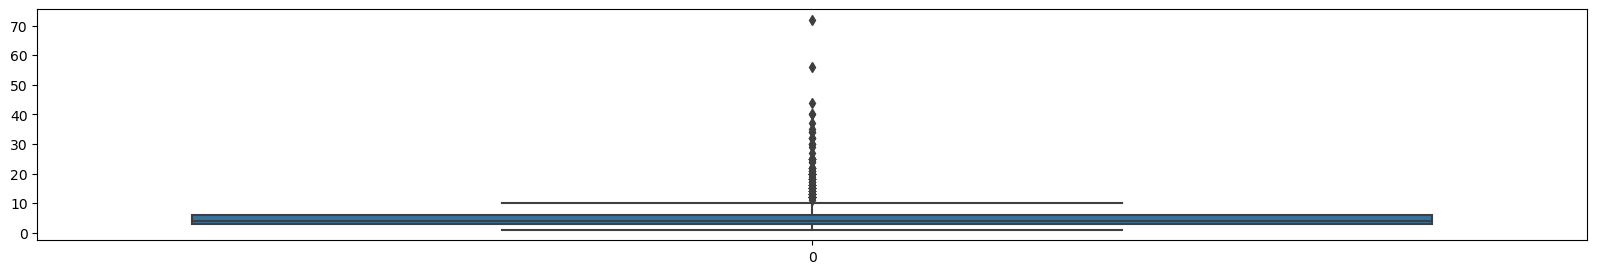

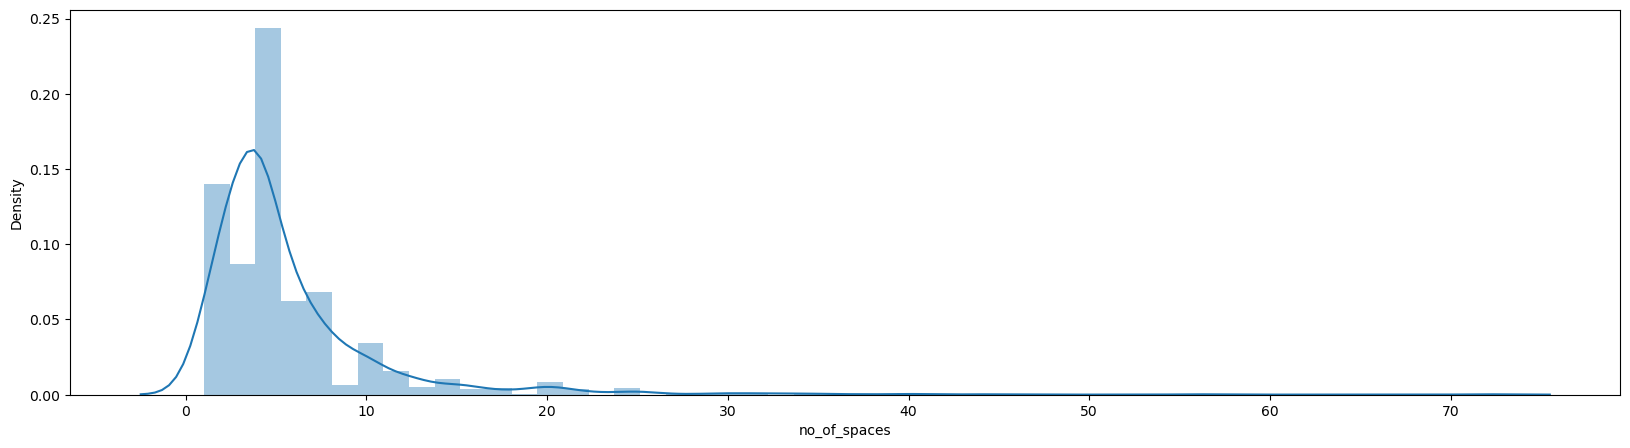

In [67]:
# Create a box plot for the 'no_of_spaces' column
fig, ax = plt.subplots(figsize = (20, 3))
sns.boxplot(df.no_of_spaces)

# Create a distribution plot for the 'no_of_spaces' column
fig, ax = plt.subplots(figsize = (20, 5))
sns.distplot(df.no_of_spaces)

In [68]:
# Calculate and print the mean and median values for the 'no_of_spaces' column
print('The mean is:', df['no_of_spaces'].mean())
print('The median is:', df['no_of_spaces'].median())

The mean is: 5.638297872340425
The median is: 4.0


Due to the right-skewed distribution of this column, using the mean or mode to replace missing values is not advisable. Instead, the median of the distribution will be used as the replacement value.

In [69]:
# Fill missing values in the 'no_of_spaces' column with the median value
df['no_of_spaces'] = df['no_of_spaces'].fillna(df['no_of_spaces'].median())
df['no_of_spaces'].isnull().sum()

0

#### `purpose`

Information on the temporary suspension of parking spots is available on the Dublin City Council website. The primary reasons for suspension include filming, delivery (set-down and collection), building work, office relocation, and broadcasting units. The "purpose" column should be examined to determine how the values can be organized. [(suspension-paid-parking)](https://www.dublincity.ie/residential/parking-dublin-city-centre/suspension-paid-parking)

In [70]:
# Iterate over the unique values in the 'purpose' column and print each value
unique_values = df['purpose'].value_counts()
for index in unique_values.index:
    print(index)

Filming
Outside Broadcast
Film Vehicles
Roadhog
Film Unit
FM104 Roadhog
Filiming Vehicles
To allow traffic to flow while loading
Broadcast
Outside Broadcast Unit
Filming Vehicles
To allow traffic to flow freely
Parking of Film Vehicles
Company Lorry
Rugby fanzone
Position of Pump and Builders Trucks
Film Vehicle
Parking of Filming Vehicles
Office Removal
Office Move
Parking of Film Unit
Temporary loading bay
Film Shoot
OBU
Moving Office
Loading
To park trucks to facilitate filming for RTE Series
Facilitate Filming
Deliveries to site
Facilitate filming
The Parking Of An Outside Broadcast Unit
Access to Site
Parking of filming vehicles
filming
Removal Van
Setting up event
Allow traffic to flow freely
Delivery to a Building Site & Safety
The free-flow of traffic
Office Relocation
Safe loading during de-rig of Dublin Festival Event in the Iveagh Gardens
Removal
Deliveries for Shop Fit Out
Off Loading
Moving Premises
Film Crew Parking
Unloading
To Facilate Filiming
Programme recording in Be

The values are disorganized and difficult to interpret. An examination will determine how many are related to filming.

In [71]:
# Filter rows where the 'purpose' column contains the substring 'film' (case-insensitive)
df[df['purpose'].str.contains('film', case=False) == True]

,location_of_spaces,str_class,purpose,date,date_suspended,date_expired,duration,no_of_spaces,amount_paid
24,nutley avenue,5.0,Parking of Filming Vehicles,2006-01-20,2006-01-24,2006-01-24,1,8.0,201.1
28,mount street crescent,4.0,Filming,2006-01-25,2006-02-06,2006-02-06,1,7.0,266.0
29,mount street crescent,4.0,Filming,2006-01-25,2006-02-13,2006-02-13,1,7.0,266.0
62,strand street,6.0,Filming,2006-02-27,2006-03-01,2006-03-01,1,9.0,342.0
71,north great george's street,4.0,Filming,2006-03-06,2006-03-08,2006-03-08,1,5.0,190.0
...,...,...,...,...,...,...,...,...,...
1704,parnell street,1.0,Film Unit,2011-04-15,2011-04-22,2011-04-22,1,8.0,160.0
1712,windsor terrace,4.0,Film Unit,2011-05-04,2011-05-07,2011-05-08,2,6.0,196.8
1714,ailesbury road,2.0,Film Unit,2011-05-11,2011-05-11,2011-05-11,1,4.0,43.2
1726,oxmantown road,3.0,Filming,2011-06-01,2011-06-09,2011-06-09,1,10.0,108.0


Before modifying the values, each cell will be converted to its uppercase equivalent.

In [72]:
# Define a function to convert a value to uppercase
def replace_to_upper(val):
    return val.upper()

df['purpose'] = df['purpose'].apply(replace_to_upper)

The values will now be substituted with the primary 5 purposes. A custom function is being developed to identify values related to Filming, which will be applied to the column.

In [73]:
# Define a function to replace values containing 'film' or 'filim' with 'filming'
def replace_to_filming(val):
    if 'film' in val.lower():
        return 'filming'
    elif 'filim' in val.lower():
        return 'filming'
    else:
        return val
    
df['purpose'] = df['purpose'].apply(replace_to_filming)
df['purpose'].value_counts()

purpose
filming                                   733
OUTSIDE BROADCAST                          97
ROADHOG                                    63
FM104 ROADHOG                              42
TO ALLOW TRAFFIC TO FLOW WHILE LOADING     35
                                         ... 
RESCUE VANS                                 1
OFFIICE REMOVAL                             1
WEDDING EVENT CAR                           1
CLEAR ACCESS TO SITE                        1
SHOPFITTERS ON SITE AT SONY CENTRE          1
Name: count, Length: 383, dtype: int64

In [74]:
# Define a function to replace values related to office relocation
def replace_to_relocation(val):
    if 'office' in val.lower():
        return 'office relocation'
    elif 'ofice' in val.lower():
        return 'office relocation'
    elif 'offi' in val.lower():
        return 'office relocation'
    else:
        return val
    
df['purpose'] = df['purpose'].apply(replace_to_relocation)
df['purpose'].value_counts()

purpose
filming                               733
OUTSIDE BROADCAST                      97
office relocation                      71
ROADHOG                                63
FM104 ROADHOG                          42
                                     ... 
SERVICE PROMOTION                       1
AUDIENCE EGRESS FROM CONCERTS           1
LIVE BROADCAST                          1
OUTSIDE BROADCASTING UNIT               1
SHOPFITTERS ON SITE AT SONY CENTRE      1
Name: count, Length: 357, dtype: int64

Creating a custom function that would change the data related to Broadcasting units.

In [75]:
# List of terms related to broadcasting
broadcast = ['broadcast', 'braodcast', 'tv','news', 'recording']

# Iterate over each row in the DataFrame
for index in range(len(df.index)):
    # Get the 'purpose' value for the current row
    purpose = df.loc[index, 'purpose']
    # Check if the 'purpose' value starts with a numeric character or an uppercase letter
    if purpose[0].isnumeric() or purpose[0].isupper():
        # Convert the 'purpose' value to lowercase for easier comparison
        replacing_val = purpose.lower()
        # Iterate over each term in the 'broadcast' list
        for num in range(len(broadcast)):
            # Check if any term from the 'broadcast' list is contained within the 'purpose' value
            if broadcast[num] in replacing_val:
                # If a match is found, replace the 'purpose' value with 'broadcasting units'
                df.loc[index, 'purpose'] = 'broadcasting units'
                
df['purpose'].value_counts()

purpose
filming                                       733
broadcasting units                            236
office relocation                              71
ROADHOG                                        63
FM104 ROADHOG                                  42
                                             ... 
ERECTION OF SCAFFOLDING & REMOVAL OF CLOCK      1
CIVIL CONTRACTOR                                1
REMOVAL TRUCKS                                  1
THE DELIVERY OF FURNITURE                       1
SHOPFITTERS ON SITE AT SONY CENTRE              1
Name: count, Length: 314, dtype: int64

The same method for the values related to the Office relocation.

For Building work.

In [76]:
# List of terms related to building work
building_work = ['site', 'sight', 'buil', 'paving', 'yard', 'construc', 'upgrading', 'pavement', 'pedestr', 'creation',
                 'painting', 'demolotion', 'permanent removal', 'realignment', 'repair', 'rail work', 'crane', 
                 'installation', 'roof', 'remove glass', 'working', 'lay surface', 'contruction', 'drainage', 'demolition',
                ]

# Iterate over each row in the DataFrame
for index in range(len(df.index)):
    # Get the 'purpose' value for the current row
    purpose = df.loc[index, 'purpose']
    # Check if the 'purpose' value starts with a numeric character or an uppercase letter
    if purpose[0].isnumeric() or purpose[0].isupper():
        # Convert the 'purpose' value to lowercase for easier comparison
        replacing_val = purpose.lower()
        # Iterate over each term in the 'building_work' list
        for num in range(len(building_work)):
            # Check if any term from the 'building_work' list is contained within the 'purpose' value
            if building_work[num] in replacing_val:
                # If a match is found, replace the 'purpose' value with 'building work'
                df.loc[index, 'purpose'] = 'building work'

df['purpose'].value_counts()

purpose
filming                                            733
broadcasting units                                 236
building work                                      120
office relocation                                   71
ROADHOG                                             63
                                                  ... 
CORPORATE BUS PARKING                                1
TRANSFER OF DELEGATES TO CONFERENCE IN KILKENNY      1
ART EXHIBITION                                       1
ACCESS FOR CROWD CONTROL/ PORTOCABIN                 1
98FM BUS FOR MAYO ALIVE FESTIVAL                     1
Name: count, Length: 253, dtype: int64

And the last one for Loading and unloading.

In [77]:
# List of terms related to loading and unloading
loading_unloading = ['load', 'deliv', 'lorr', 'furniture', 'storage', 'moving', 'collection','drop off', 'delivery', 
                     'removals', 'relocating', 'materials' , 'removal']

# Iterate over each row in the DataFrame
for index in range(len(df.index)):
    # Get the 'purpose' value for the current row
    purpose = df.loc[index, 'purpose']
    # Check if the 'purpose' value starts with a numeric character or an uppercase letter
    if purpose[0].isnumeric() or purpose[0].isupper():
        # Convert the 'purpose' value to lowercase for easier comparison
        replacing_val = purpose.lower()
        # Iterate over each term in the 'loading_unloading' list
        for num in range(len(loading_unloading)):
            # Check if any term from the 'loading_unloading' list is contained within the 'purpose' value
            if loading_unloading[num] in replacing_val:
                # If a match is found, replace the 'purpose' value with 'loading and unloading'
                df.loc[index, 'purpose'] = 'loading and unloading'

df['purpose'].value_counts()

purpose
filming                             733
broadcasting units                  236
loading and unloading               220
building work                       120
office relocation                    71
                                   ... 
RESCUE VANS                           1
AUDIENCE EGRESS FROM CONCERTS         1
SERVICE PROMOTION                     1
CORPORATE BUS PARKING                 1
98FM BUS FOR MAYO ALIVE FESTIVAL      1
Name: count, Length: 169, dtype: int64

The unique values will now be checked to identify what remains.

In [78]:
# Iterate over the unique values in the 'purpose' column and print each value
unique_values = df['purpose'].value_counts()
for index in unique_values.index:
    print(index)

filming
broadcasting units
loading and unloading
building work
office relocation
ROADHOG
FM104 ROADHOG
TO ALLOW TRAFFIC TO FLOW FREELY
RUGBY FANZONE
ALLOW TRAFFIC TO FLOW FREELY
OBU
THE FREE-FLOW OF TRAFFIC
SETTING UP EVENT
UNIT PRODUCTION VEHILCES
COACH PARKING
PANDA WASTE SHREDDING TRUCK
THUNDERBUS
PARKING CATERING VEHICLES
COMPOUND AREA TO STORE SPOIL
EXHIBITOR SET UP DAY
PARK ONE SINGLE DECK BUS
TEMPORARY MOBILE LIBRARY SERVICE
CULTURE NIGHT PRODUCTION VEHICLES
HOGGIE
VEHICLES FOR EVENTS WORKS
MOBILE UNIT INFORMATION
PARKING LIBRARY BUS AND ASSOCIATED VEHICLES AS PART OF THE CHINESE NEW YEAR CARNIVAL EVENT
COMMERCIAL
GUINNESS 250 EVENT
TO PARK THE FESTIVAL OF CHARIOTS CARTS
ARTHURS DAY PRODUCTION VEHICLES
PARKING OF CARS
INFORMATION MOBILE UNIT
DE-RIG EVENT
MINISTER/TANAISTE MARY COUGHLAN
PHOTOSHOOT FOR CLIENT
INSTALLING KITCHEN
AUDIENCE PICK-UP/ VEHICLES FROM THE SHOW WILL ALSO BE PARKED HERE DURING THE DAY
TO SERVICE CHRIST CHURCH LOCATION AS AN OVERSPILL ZONE FOR BUSES , TRUCKS 

The output from the previous cell indicates that the primary five purpose values have been successfully grouped. However, there are additional values that do not align with any of the primary categories. These will be categorized as "others," which are associated with celebrations, roadhog removal, carnivals, charitable activities, and displays.

In [79]:
# Define a function to categorize values in the 'purpose' column
def replace_to_others(val):
    if val == 'filming':
        return val
    elif val == 'broadcasting units':
        return val
    elif val == 'loading and unloading':
        return val
    elif val == 'building work':
        return val
    elif val == 'office relocation':
        return val
    else:
        return 'others'
    
# Apply the function to the 'purpose' column to categorize values
df['purpose'] = df['purpose'].apply(replace_to_others)
df['purpose'].value_counts()

purpose
filming                  733
others                   362
broadcasting units       236
loading and unloading    220
building work            120
office relocation         71
Name: count, dtype: int64

In [80]:
# Count the number of missing values in the 'purpose' column
df['purpose'].isnull().sum()

0

#### 'date'

In the future, only the years from this column will be used for analysis. The column will be renamed to "year," and the months and days will be removed from the values.

In [81]:
# Rename the 'date' column to 'year'
df = df.rename(columns={'date' : 'year'})
# Extract the year component from the 'year' column
df['year'] = df['year'].dt.year

In [82]:
# Count the occurrences of each unique year in the 'year' column
df['year'].value_counts()

year
2006    516
2007    367
2008    336
2009    224
2010    213
2011     85
2026      1
Name: count, dtype: int64

It looks like the column contains a faulty value.

In [83]:
# Filter rows where the 'year' column equals 2026
df.loc[(df['year'] == 2026)] 

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid
203,argyle road,6.0,building work,2026,2026-06-07,2026-07-23,46,1.0,1400.0


One more input error. It has to be 2006 because the first 517 rows are values associated with the year 2006.

In [84]:
# Modify values for index 203: set 'year' to 2006 and 'date_suspended' to June 7, 2006
df.loc[203, 'year'] = 2006
df.loc[203, 'date_suspended'] = pd.to_datetime('2006-06-07')

df['year'].value_counts()

year
2006    517
2007    367
2008    336
2009    224
2010    213
2011     85
Name: count, dtype: int64

Only 85 values are available for the year 2011. The year will be examined to understand why it contains such a small number of entries.

In [85]:
# Create a copy of rows where the 'year' column equals 2011
rows_of2011 = df.loc[(df['year']) == 2011].copy()

rows_of2011

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid
1657,temple street,4.0,broadcasting units,2011,2011-01-12,2011-01-12,1,7.0,287.0
1658,temple street,4.0,broadcasting units,2011,2011-01-19,2011-01-19,1,7.0,287.0
1659,castle street,3.0,filming,2011,2011-01-11,2011-01-11,1,5.0,100.0
1660,hatch street,2.0,filming,2011,2011-01-12,2011-01-12,1,5.0,100.0
1661,clonmel street,5.0,filming,2011,2011-01-11,2011-01-11,1,5.0,100.0
...,...,...,...,...,...,...,...,...,...
1737,ballsbridge avenue,6.0,loading and unloading,2011,2012-02-25,2012-02-25,1,2.0,82.0
1738,merrion road,2.0,others,2011,2012-03-10,2012-03-10,1,6.0,246.0
1739,ballsbridge avenue,6.0,loading and unloading,2011,2012-03-10,2012-03-10,1,2.0,82.0
1740,fairview,5.0,others,2011,2011-07-26,2011-07-26,1,6.0,114.0


In [86]:
# Convert each date in the 'date_suspended' column to a numeric representation of year and month combined
rows_of2011['date_suspended'] = rows_of2011['date_suspended'].map(lambda x: 100*x.year + x.month)
rows_of2011['date_suspended'].value_counts()

date_suspended
201104    17
201105    14
201103    13
201106    11
201101    10
201102     9
201108     4
201202     4
201203     2
201107     1
Name: count, dtype: int64

The results from the previous cell show that the entries for the year 2011 are limited to January through August, indicating incomplete data for that year in the primary DataFrame. Similarly, the year 2012 contains only 6 entries. Based on this, rows with data from the years 2011 and 2012 will be removed.

In [87]:
# Create a copy of the DataFrame excluding rows where the 'year' column equals 2011
df = df.loc[(df['year']) != 2011].copy()
df['year'].value_counts()

year
2006    517
2007    367
2008    336
2009    224
2010    213
Name: count, dtype: int64

In [88]:
# Convert the 'year' column to integer data type
df['year'] = df['year'].astype(int)

#### `date_suspended`

Input errors in the "date suspended" column will be checked. Since days and months were already verified during the handling of the "duration" column, any errors should only be related to the year. A new DataFrame will be created, and the 'map()' method will be used with 'lambda' to extract only the year value from the data.

In [89]:
# Extract the year component from the 'date_suspended' column and count occurrences of each unique year
check_date = df.copy()
check_date['date_suspended'] = check_date['date_suspended'].map(lambda x: x.year)
check_date['date_suspended'].value_counts()

date_suspended
2006    510
2007    367
2008    344
2009    222
2010    211
2005      1
2001      1
2011      1
Name: count, dtype: int64

Three distinct year values are shown, each with a count of one. These could be errors or valid entries. The entire rows in the main DataFrame will be examined to verify their accuracy. If any incorrect data is found, it will be replaced with the correct value.

In [90]:
# Filter rows where the 'date_suspended' column equals 2005
check_date.loc[(check_date['date_suspended']) == 2005]

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid
6,townsend street,2.0,loading and unloading,2006,2005,2006-01-13,5,2.0,456.0


In [91]:
# Filter rows where the 'date_suspended' column equals 2001
check_date.loc[(check_date['date_suspended']) == 2001]

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid
1508,creighton street,4.0,filming,2010,2001,2010-07-05,1,6.0,246.0


In [92]:
# Select rows with index 6 and 1508 from the DataFrame
df.loc[(6, 1508), :]

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid
6,townsend street,2.0,loading and unloading,2006,2005-01-09,2006-01-13,5,2.0,456.0
1508,creighton street,4.0,filming,2010,2001-07-05,2010-07-05,1,6.0,246.0


The input has been identified as incorrect and will be replaced with the correct value.

In [93]:
# Assign specific dates to the 'date_suspended' column for rows with index 6 and 1508
df.loc[6, 'date_suspended'] = '2006-01-09' 
df.loc[1508, 'date_suspended'] = '2010-07-05'

# Convert the 'date_suspended' column to datetime format
df['date_suspended'] = pd.to_datetime(df['date_suspended'])

The values are now correct and complete. The next step is to classify the values by the day of the week. This will enable future analysis of which day the government receives more earnings from the parking bays.

In [94]:
# Create a new column 'day' and map the weekday of 'date_suspended' to each row
df['day'] = df['date_suspended']
df['day'] = df['date_suspended'].map(lambda x: x.weekday())
df.head()

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid,day
0,commons street,4.0,others,2006,2006-01-23,2006-01-23,1,5.0,152.0,0
1,saint stephens green east,1.0,loading and unloading,2006,2006-06-22,2006-06-22,1,3.0,114.0,3
2,saint stephens green east,1.0,filming,2006,2006-01-09,2006-01-09,1,4.0,152.0,0
3,saint stephens green east,1.0,others,2006,2006-01-09,2006-01-09,1,4.0,152.0,0
4,molesworth street,4.0,filming,2006,2006-01-09,2006-01-09,1,12.0,152.0,0


### 2.5.  Final adjustments to the columns.

The values in the columns are now organized and prepared for analysis. However, before proceeding, columns that will not be used in future analyses will be removed. The "date_expired" column is being dropped as a new "duration" column has already been added. The duration allows for the calculation of the expiration date if needed. The "location_of_spaces" column is also being removed since its values were already used to extract data for the "str_class" column, and more generalized information will be utilized moving forward. Apologies if this choice is incorrect.

In [95]:
df.head()

,location_of_spaces,str_class,purpose,year,date_suspended,date_expired,duration,no_of_spaces,amount_paid,day
0,commons street,4.0,others,2006,2006-01-23,2006-01-23,1,5.0,152.0,0
1,saint stephens green east,1.0,loading and unloading,2006,2006-06-22,2006-06-22,1,3.0,114.0,3
2,saint stephens green east,1.0,filming,2006,2006-01-09,2006-01-09,1,4.0,152.0,0
3,saint stephens green east,1.0,others,2006,2006-01-09,2006-01-09,1,4.0,152.0,0
4,molesworth street,4.0,filming,2006,2006-01-09,2006-01-09,1,12.0,152.0,0


In [96]:
# Reset index of the DataFrame and select specific columns
df = df.reset_index()
df = df.loc[:, ['date_suspended', 'year', 'day', 'purpose', 'str_class', 'no_of_spaces', 'duration', 'amount_paid']].copy()

In [97]:
# Display a concise summary of DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_suspended  1657 non-null   datetime64[ns]
 1   year            1657 non-null   int32         
 2   day             1657 non-null   int64         
 3   purpose         1657 non-null   object        
 4   str_class       1657 non-null   float64       
 5   no_of_spaces    1657 non-null   float64       
 6   duration        1657 non-null   int64         
 7   amount_paid     1657 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(1)
memory usage: 97.2+ KB


In [98]:
# Convert 'no_of_spaces', 'duration', and 'str_class' columns to integer type
df['no_of_spaces'] = df['no_of_spaces'].astype(int)
df['duration'] = df['duration'].astype(int)
df['str_class'] = df['str_class'].astype(int)

# Convert 'year' column to object type
df['year'] = df['year'].astype(object)

In [99]:
# Display a concise summary of DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_suspended  1657 non-null   datetime64[ns]
 1   year            1657 non-null   object        
 2   day             1657 non-null   int64         
 3   purpose         1657 non-null   object        
 4   str_class       1657 non-null   int32         
 5   no_of_spaces    1657 non-null   int32         
 6   duration        1657 non-null   int32         
 7   amount_paid     1657 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(3), int64(1), object(2)
memory usage: 84.3+ KB


In [100]:
# Get the dimensions of the DataFrame (number of rows, number of columns)
df.shape

(1657, 8)

##   3.   STATISTICAL ANALYSIS

### 3.1. Descriptive statistics 

Descriptive statistics are used to describe, summarize, and present the key features of a dataset. These statistics help in better understanding the data. In this section, only the available data from the sample will be represented, without involving theories, inferences, probabilities, or conclusions. Descriptive statistics are divided into four main categories, and for this assignment, three of them will be applied: measures of frequency, central tendency, and dispersion or variation.

### *Measures of frequency* 

Let's begin descriptive statistics with the frequency measure. The frequency of an occurrence in statistics is the number of times the observation occurred during an experiment or research. These frequencies are often shown graphically or in a table. 

In [101]:
# Check the Data Frame
df.head()

,date_suspended,year,day,purpose,str_class,no_of_spaces,duration,amount_paid
0,2006-01-23,2006,0,others,4,5,1,152.0
1,2006-06-22,2006,3,loading and unloading,1,3,1,114.0
2,2006-01-09,2006,0,filming,1,4,1,152.0
3,2006-01-09,2006,0,others,1,4,1,152.0
4,2006-01-09,2006,0,filming,4,12,1,152.0


I'll use frequency distribution for my dataset's nominal and ordinal columns.

In [102]:
#Count unique values in the 'purpose' column and display as a DataFrame
df['purpose'].value_counts().to_frame()

,count
purpose,
filming,709
others,338
broadcasting units,224
loading and unloading,206
building work,114
office relocation,66


In [103]:
# Count the normalized frequency of unique values in the 'purpose' column and display as a DataFrame
df['purpose'].value_counts(normalize=True).to_frame()

,proportion
purpose,
filming,0.427882
others,0.203983
broadcasting units,0.135184
loading and unloading,0.124321
building work,0.068799
office relocation,0.039831


By grouping the data based on the reason for the suspension, it becomes clear that the majority of suspensions were due to filming. Between 2006 and 2010, there were 709 suspensions for filming, making up almost 43% of all suspensions during that period. Office relocation is the least common cause, accounting for only 4% of all parking suspensions.

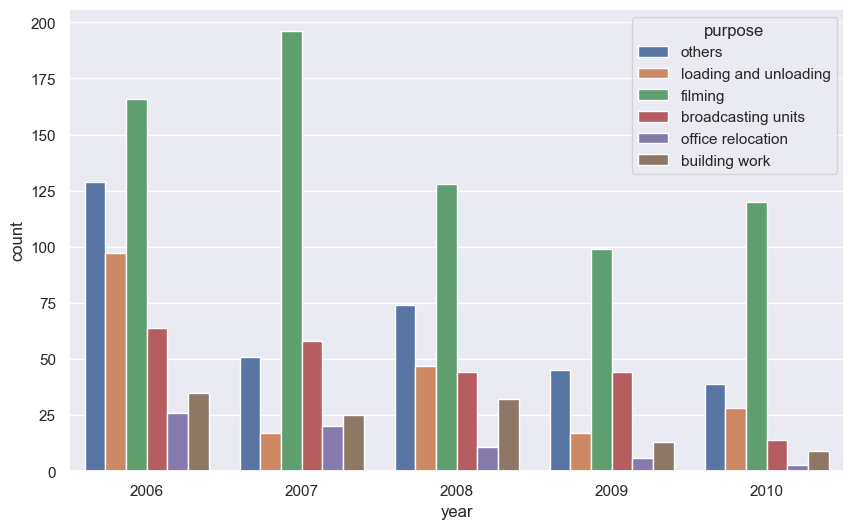

In [104]:
# Create a countplot to show the distribution of 'year' with 'purpose' as the hue, categorized by purpose
sns.set(rc = {'figure.figsize':(10,6)})
sns.countplot(x='year', hue = 'purpose', data=df);

The bar graph above demonstrates that, between 2006 and 2010, the most common reason for suspensions was filming. Whereas, the number of office relocation is the lowest each year. Additionally, the counts for the rest of the purposes vary uniquely annually.

In [105]:
# Group the data by 'purpose' and calculate the sum of 'no_of_spaces' and 'amount_paid' for each group
df.groupby(['purpose'])[['no_of_spaces', 'amount_paid']].sum()

,no_of_spaces,amount_paid
purpose,,
broadcasting units,966,43082.30
building work,438,147565.80
filming,5628,248253.74
loading and unloading,614,80736.60
office relocation,240,14661.40
others,1475,114423.32


The table shows that the filming has the highest numbers in both categories when we count the number of spaces and the number of earnings for each purpose. Once again, office relocation has the lowest counts for both. One interesting observation is that while building work suspension uses relatively few parking spaces, the amount of money the government makes from it is far more than the average for other uses.

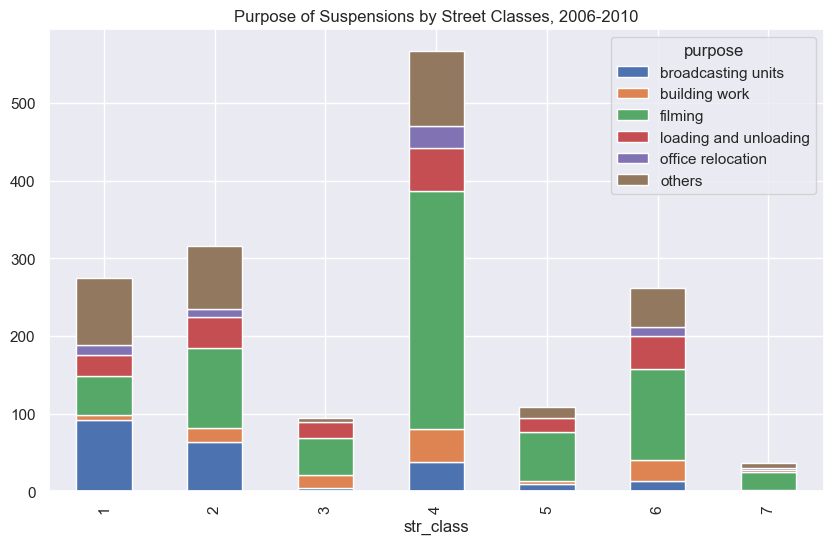

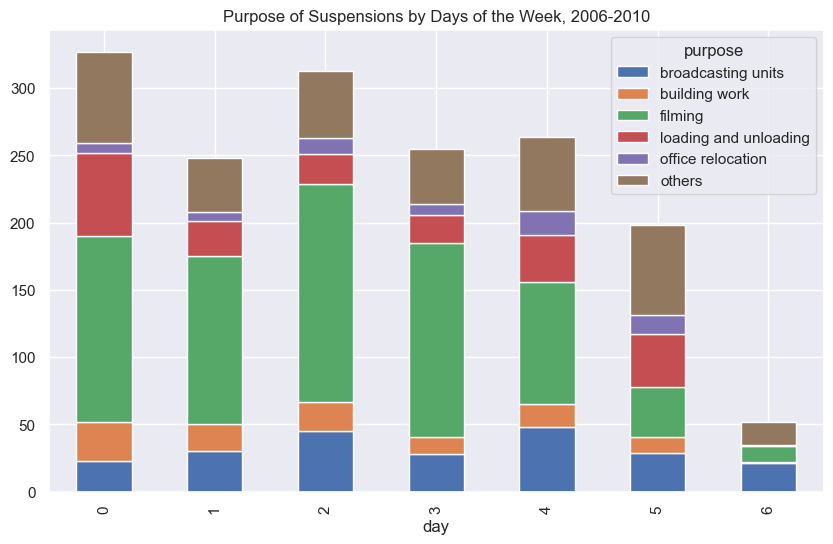

In [106]:
# Group the data by 'str_class' and 'purpose', then plot the stacked bar chart to show the number of suspensions by street class and purpose
df.groupby(['str_class', 'purpose']).size().unstack().plot(kind='bar', stacked=True, 
                                                           title='Purpose of Suspensions by Street Classes, 2006-2010')

# Group the data by 'day' and 'purpose', then plot the stacked bar chart to show the number of suspensions by day of the week and purpose
df.groupby(['day', 'purpose']).size().unstack().plot(kind='bar', stacked=True, 
                                                           title='Purpose of Suspensions by Days of the Week, 2006-2010');

The stacked graph "Purpose of Suspensions by Street Classes" shows that the 4th street class is where most suspensions occurred, and it is also where filming happens most frequently overall. Although the 7th street class had the lowest total count of suspensions, it had the highest number of filming suspensions. An interesting observation from this graph is that the 1st street class is the only place where the count of filming suspensions surpassed the number of broadcasting and other types of suspensions.

The second graph illustrates the number of suspensions by day of the week. It shows that the government receives the highest number of suspension requests during weekdays, with Sunday having the lowest. On weekdays, filming suspensions lead by number, but the trend changes on weekends. On Sunday, the highest number of suspensions is for other purposes, and on Saturday, broadcasting and other purposes account for a higher number of parking suspensions.

### *Measures of central tendency*

A measure of central tendency is a summary measure that represents the middle or center of a data set, condensing it into a single value. The three main measures of central tendency are the mode, the median, and the mean. Each measure provides a different perspective on what constitutes the typical or central value in a distribution.

In this section of the assignment, the goal is to analyze the central values of the continuous variables "number of spaces," "duration," and "amount paid." The means, medians, and modes for these columns will be calculated.

`mean`

In [107]:
# Calculate the mean of the columns 'no_of_spaces', 'duration', and 'amount_paid'
df[['no_of_spaces', 'duration', 'amount_paid']].mean()

no_of_spaces      5.649366
duration          3.118286
amount_paid     391.504623
dtype: float64

`median`

In [108]:
# Calculate the median of the columns 'no_of_spaces', 'duration', and 'amount_paid'
df[['no_of_spaces', 'duration', 'amount_paid']].median()

no_of_spaces      4.0
duration          1.0
amount_paid     190.0
dtype: float64

`mode`

In [109]:
# Calculate the mode of the columns 'no_of_spaces', 'duration', and 'amount_paid'
df[['no_of_spaces', 'duration', 'amount_paid']].mode()

,no_of_spaces,duration,amount_paid
0,4,1,152.0


All three columns exhibit a right-skewed distribution, as indicated by the computed data. Given that the mean is greater than both the median and the mode for each of these columns, this observation is confirmed. As an example, a boxplot and a bar graph of the central values will be created for one of the columns.

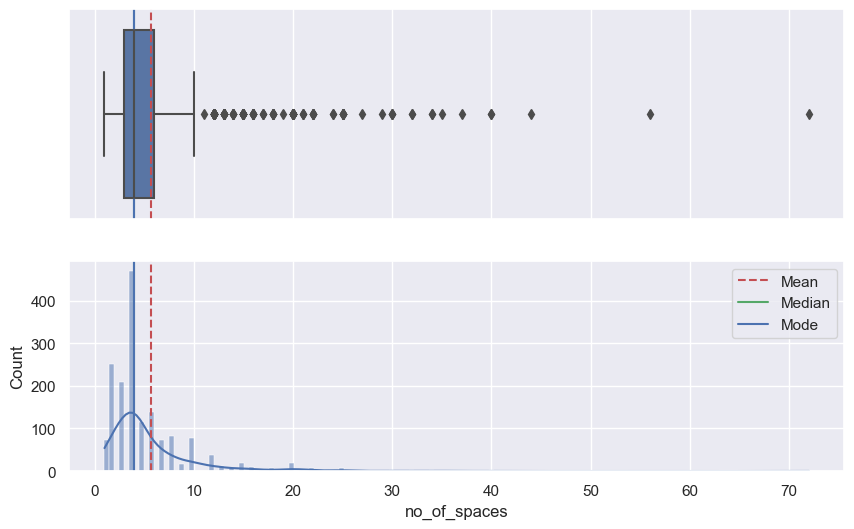

In [110]:
# Plotting boxplot and histogram for 'no_of_spaces' with mean, median, and mode lines

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (100, 100)})

mean=df['no_of_spaces'].mean()
median=df['no_of_spaces'].median()
mode=df['no_of_spaces'].mode().values[0]

sns.boxplot(data=df, x="no_of_spaces", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=df, x="no_of_spaces", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

### *Measures of dispersion* 

Every dataset contains some level of variability within its range. Variability is defined as the extent to which data points differ from each other and the center of the distribution. This is also referred to as the spread, scatter, or dispersion of data. Dispersion describes how much the values deviate from the average value. Measures of dispersion are used to assess the variability of data. Like central tendency, variability is crucial for summarizing the characteristics of a dataset, as it aids in presenting the data's facts and figures. The dispersion measures will be calculated and summarized.

`Range`

The spread of data between the lowest and highest values in a distribution is referred to as the range. The range for columns with continuous data will now be determined.

In [111]:
# Calculating and printing the range for each column in 'no_of_spaces', 'duration', and 'amount_paid'
columns = ['no_of_spaces', 'duration', 'amount_paid']

for x in columns:
    minimum = df[x].min()
    maximum = df[x].max()
    column_range = maximum - minimum
    print('Range of the column', x, 'is:', column_range)

Range of the column no_of_spaces is: 71
Range of the column duration is: 485
Range of the column amount_paid is: 17185.0


The range is quite a helpful indication of how spread out the data is, but it has some severe limitations. It's because sometimes data can have outliers that are widely off the other data points. In these cases, the range might not give a true indication of the spread of data for the column "duration". Due to its outliers, the column "duration" has a very high range value.

`IQR`

The interquartile range (IQR) represents the spread of the middle 50% of a data set. It offers insight into the distribution of values and the extent of clustering. The IQR will be calculated for the columns with continuous values, and the results will be displayed below.

In [112]:
# Calculating and printing the interquartile range (IQR) for each column in 'no_of_spaces', 'duration', and 'amount_paid'
columns = ['no_of_spaces', 'duration', 'amount_paid']

for x in columns:
    q75, q25 = np.percentile(df[x], [75 ,25])
    iqr = q75 - q25
    print('Interquartile range for the column', x, 'is:', iqr)

Interquartile range for the column no_of_spaces is: 3.0
Interquartile range for the column duration is: 1.0
Interquartile range for the column amount_paid is: 232.6


The high value for the column 'amount_paid' indicates that the central portion of my data is spread out further. Conversely, smaller values for "no_of_spaces" and "duration" show that the middle values cluster more tightly.

**Variance**

The term variance refers to a statistical measurement of the spread between numbers in a data set. More specifically, variance measures how far each number in the collection is far from the mean (average) and, thus, from every other number in the set. I will calculate the variance for the columns with continuous values and print the results below.

In [113]:
# Calculating and printing the variance for each column in 'no_of_spaces', 'duration', and 'amount_paid'
columns = ['no_of_spaces', 'duration', 'amount_paid']

for x in columns:
    variance = df[x].var()
    print('The variance for the column', x, 'is:', variance)

The variance for the column no_of_spaces is: 27.375170190000507
The variance for the column duration is: 209.55725599782858
The variance for the column amount_paid is: 761917.9930479446


The more spread the data, the larger the variance is in relation to the mean. In comparison to the variation of the column "amount paid", the variance of the columns "duration" and "no_of_spaces" is relatively low. It indicates that the "amount_paid" column has a widespread.

**Standard deviation**

The standard deviation is the average amount of variability in my data set. I will calculate the standard deviation for the columns with continuous values and print the results below.

In [114]:
# Calculating and printing the standard deviation for each column in 'no_of_spaces', 'duration', and 'amount_paid'
columns = ['no_of_spaces', 'duration', 'amount_paid']

for x in columns:
    st_deviation  = df[x].std()
    print('The standart deviation for the column', x, 'is:', st_deviation)

The standart deviation for the column no_of_spaces is: 5.232128648074367
The standart deviation for the column duration is: 14.4760925666365
The standart deviation for the column amount_paid is: 872.8791400004611


Simply, I could just use the method "describe()" instead of computing everything separately. This method calculates:

    The count of values
    The number of unique values
    The top (most frequent) value
    The frequency of your top value
    The mean, standard deviation, min and max values
    The percentiles of your data: 25%, 50%, 75% by default

In [115]:
# Generating descriptive statistics (count, mean, std, min, 25%, 50%, 75%, max) for all numerical columns in the DataFrame
df.describe()

,date_suspended,day,str_class,no_of_spaces,duration,amount_paid
count,1657,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000
mean,2008-01-25 21:00:06.517803264,2.412191,3.512975,5.649366,3.118286,391.504623
min,2006-01-09 00:00:00,0.000000,1.000000,1.000000,1.000000,16.000000
25%,2006-10-25 00:00:00,1.000000,2.000000,3.000000,1.000000,121.600000
50%,2007-10-30 00:00:00,2.000000,4.000000,4.000000,1.000000,190.000000
75%,2009-01-28 00:00:00,4.000000,4.000000,6.000000,2.000000,354.200000
max,2011-01-05 00:00:00,6.000000,7.000000,72.000000,486.000000,17201.000000
std,NaN,1.771942,1.722256,5.232129,14.476093,872.879140


The output from the "explain()" method reveals that the columns "no of spaces," "duration," and "amount paid," which contain continuous data, exhibit a right-skewed distribution. This is reflected in the median and mean values of these columns. Despite the low IQR values for "duration" and "amount paid," the significant range between their minimum and maximum values indicates the presence of outliers. Additionally, the "amount paid" column shows a relatively high standard deviation, suggesting that the values are widely spread across the distribution.

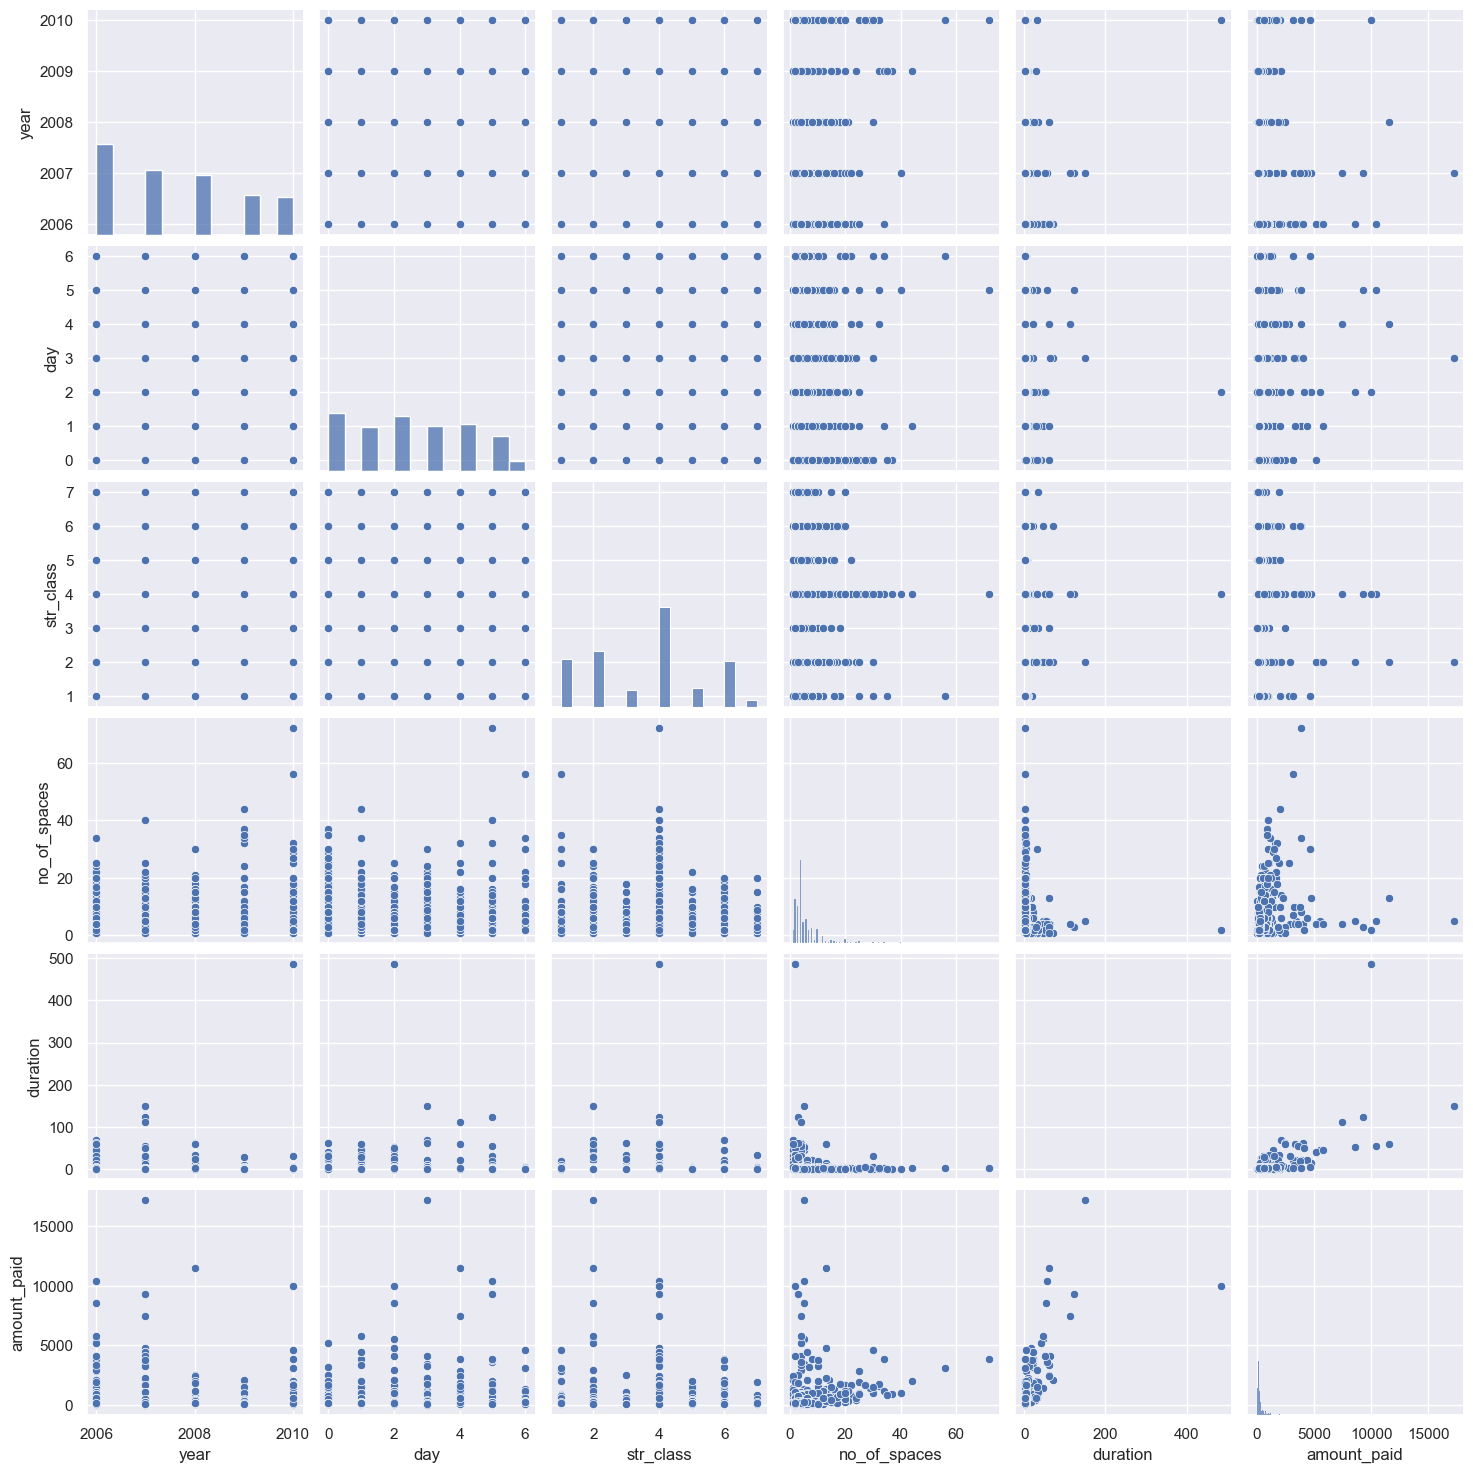

In [116]:
# Plotting pairwise relationships and distribution for numerical columns in the DataFrame
sns.pairplot(df)

The 'pairplot()' method from the 'seaborn' library allows for plotting histograms of the data and correlation scatter plots. No significant patterns are observed in the plots. However, the correlation between the "amount_paid" and "duration" columns may be worth further investigation. This can be examined more closely using a correlation heatmap.

In [117]:
# Plotting pairwise relationships and distribution for numerical columns in the DataFrame
df.select_dtypes(include='number').corr()

,day,str_class,no_of_spaces,duration,amount_paid
day,1.000000,-0.072296,0.036311,-0.024314,0.001768
str_class,-0.072296,1.000000,0.060516,0.012558,0.028085
no_of_spaces,0.036311,0.060516,1.000000,-0.049402,0.253263
duration,-0.024314,0.012558,-0.049402,1.000000,0.659387
amount_paid,0.001768,0.028085,0.253263,0.659387,1.000000


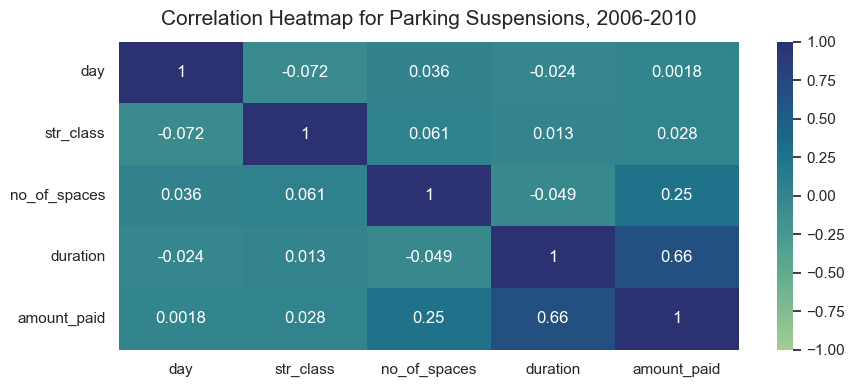

In [118]:
# Plotting a heatmap to visualize the correlation between numerical columns in the DataFrame
plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(df.select_dtypes(include='number').corr(), vmin=-1, vmax=1, annot=True, cmap='crest')
heatmap.set_title('Correlation Heatmap for Parking Suspensions, 2006-2010', fontdict={'fontsize':15}, pad=12);

As previously mentioned, the "duration" and "amount_paid" columns have a correlation value of 0.66, indicating a moderate positive linear relationship. The other columns show almost no correlation with each other.

### 3.2. Poisson distribution

In this section, the Poisson distribution will be applied to explain certain data from the dataset. By using the Poisson distribution, the probability of an event occurring within a given time frame can be calculated.

In [119]:
# Filtering the dataset for "filming" purpose and resetting the index for further analysis with Poisson distribution
for_poisson = df.loc[(df['purpose'] == 'filming')].reset_index().iloc[:, 1:].copy()
for_poisson.head(2)

,date_suspended,year,day,purpose,str_class,no_of_spaces,duration,amount_paid
0,2006-01-09,2006,0,filming,1,4,1,152.0
1,2006-01-09,2006,0,filming,4,12,1,152.0


A new DataFrame was created to preserve the integrity of the original one.

The descriptive analysis revealed that filming suspensions are the most frequent compared to other reasons. Given its high frequency, the Poisson distribution can be applied to analyze it and estimate the likely number of filming suspension events in the upcoming year or month.

Since suspensions occur sporadically, only the year and month values from the "date_suspended" column are retained. This simplifies the process of calculating the lambda value for the suspensions, as using daily data would complicate the analysis. The best approach is to focus on monthly occurrences for this calculation.

In [120]:
# Convert 'date_suspended' to YEAR-MONTH format and apply to the DataFrame
for_poisson['date_suspended'] = for_poisson['date_suspended'].apply(lambda x: x.strftime('%Y-%m')) 

# Calculate the number of occurrences for each month and display the result
value_count = for_poisson.groupby(['date_suspended'])['purpose'].value_counts().unstack().astype(int)
value_count

purpose,filming
date_suspended,
2006-01,4
2006-02,2
2006-03,27
2006-04,11
2006-05,15
2006-06,10
2006-07,16
2006-08,15
2006-09,18


The next move is finding the sum of the values and the mean.

In [121]:
the_sum = value_count.values.sum()       #total number of counts
total_month = len(value_count)           #number of the monhts
mean_lambda = the_sum/total_month        #mean or lambda for poisson distribution
print('The total of the occurrence values for the filming purposes:', the_sum)
print('This is the occurrence of', len(value_count), 'months.')
print('The mean (lambda) value of the occurrence:', mean_lambda)

The total of the occurrence values for the filming purposes: 709
This is the occurrence of 59 months.
The mean (lambda) value of the occurrence: 12.016949152542374


The Poisson distribution probability can now be calculated using lambda.

In [122]:
# Calculating the Poisson distribution probability for no more than 15 suspensions in the upcoming month
prediction = poisson.cdf(k=15, mu=12.016949152542374) * 100
print('The probability that no more than 15 suspensions will occur in the upcoming month is', prediction.round(), '%.')

The probability that no more than 15 suspensions will occur in the upcoming month is 84.0 %.


<Axes: xlabel='filming', ylabel='Density'>

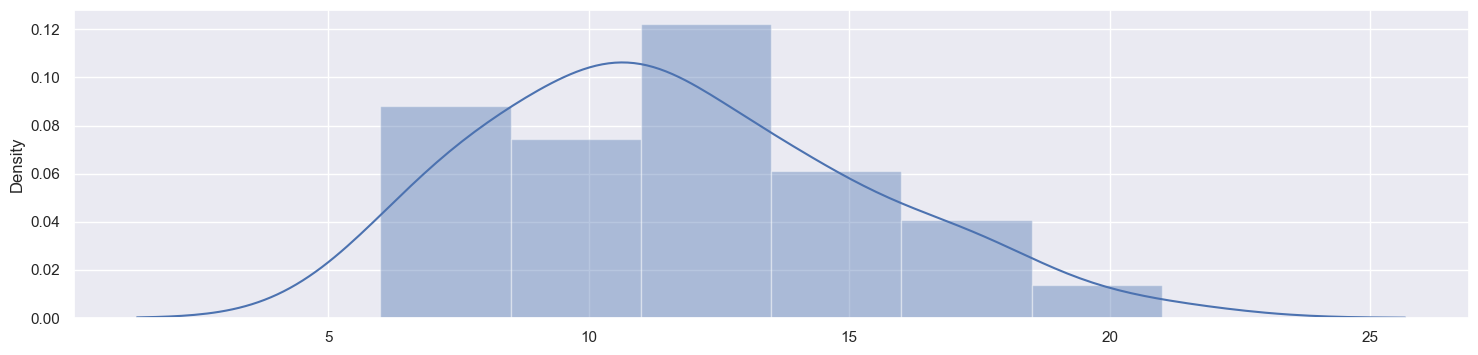

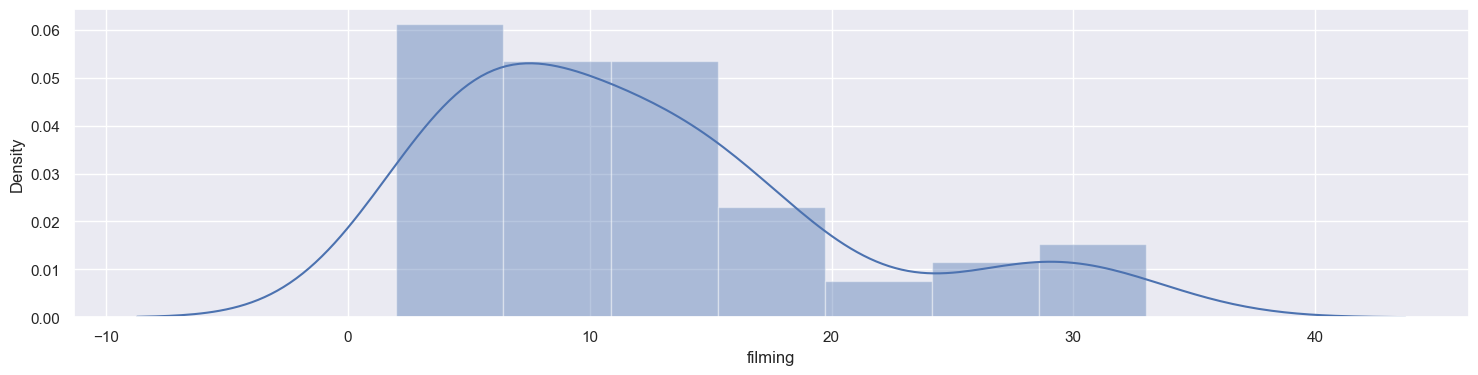

In [123]:
# Generate and visualize Poisson-distributed data and another distribution
random.seed(14)
x= poisson.rvs(mu=12.016949152542374, size=59)

fig, ax = plt.subplots(figsize = (18, 4))
sns.distplot(x)

fig, ax = plt.subplots(figsize = (18, 4))
sns.distplot(value_count.filming)

A bar plot of randomly seeded numbers and a plot of the original numbers from the 'purpose' column have been compared. While there are some similarities between the two, a probability distribution fitting test needs to be conducted to verify the fit.

## 4 MACHINE LEARNING

With detailed information about the columns obtained from statistical analysis, the next step involves conducting machine learning experiments using regression and classification models.

### 4.1 Regression Models

In the context of regression modeling, the column of primary interest from a sales perspective is the cost associated with the parking bays. Therefore, the 'amount_paid' column is selected as the target variable. Commonly used regression models will be applied to evaluate their performance and determine which model is most effective for this task.

In [124]:
# Split features and target
X = df.drop('amount_paid', axis=1)
y = df['amount_paid']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=630)

# Define preprocessing
numeric_features = ['year', 'day', 'str_class', 'no_of_spaces', 'duration']
categorical_features = ['purpose']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Define models and hyperparameters
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'model__alpha': [0.1, 1.0, 10.0]}),
    'Lasso Regression': (Lasso(), {'model__alpha': [0.01, 0.1, 1.0]}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 5]
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    })
}

# Train and evaluate models
results = {}

for name, (model, params) in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

A machine learning pipeline was created to predict the *amount_paid* based on various features in the dataset. The process involved the following steps:
* *Data Splitting*: The target variable (amount_paid) was separated from the features (X), and the data was divided into training and testing sets.
* *Preprocessing*: Data preprocessing was carried out using StandardScaler for numerical features and OneHotEncoder for categorical features to prepare the dataset for modeling.
* *Model Definition*: Several regression models, including Linear Regression, Ridge, Lasso, Random Forest, and Gradient Boosting, were defined, with hyperparameters specified for tuning.
* *Model Training and Evaluation*: GridSearchCV was used to optimize the hyperparameters of each model, which were trained on the training set and evaluated on the test set using performance metrics such as MAE, MSE, RMSE, and R².

The objective was to compare the performance of different regression models and identify the best one for predicting the amount_paid based on the evaluation metrics.

Now, let's examine the results to determine which model performed the best for the project dataset.

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,266.199299,3145708.523025,1773.614536,-4.521969
1,Ridge Regression,263.693337,3066889.723322,1751.253758,-4.383611
2,Lasso Regression,263.723802,3115906.969809,1765.193182,-4.469655
3,Random Forest,108.179398,104639.938365,323.480971,0.816315
4,Gradient Boosting,128.329384,161335.474009,401.665874,0.716792


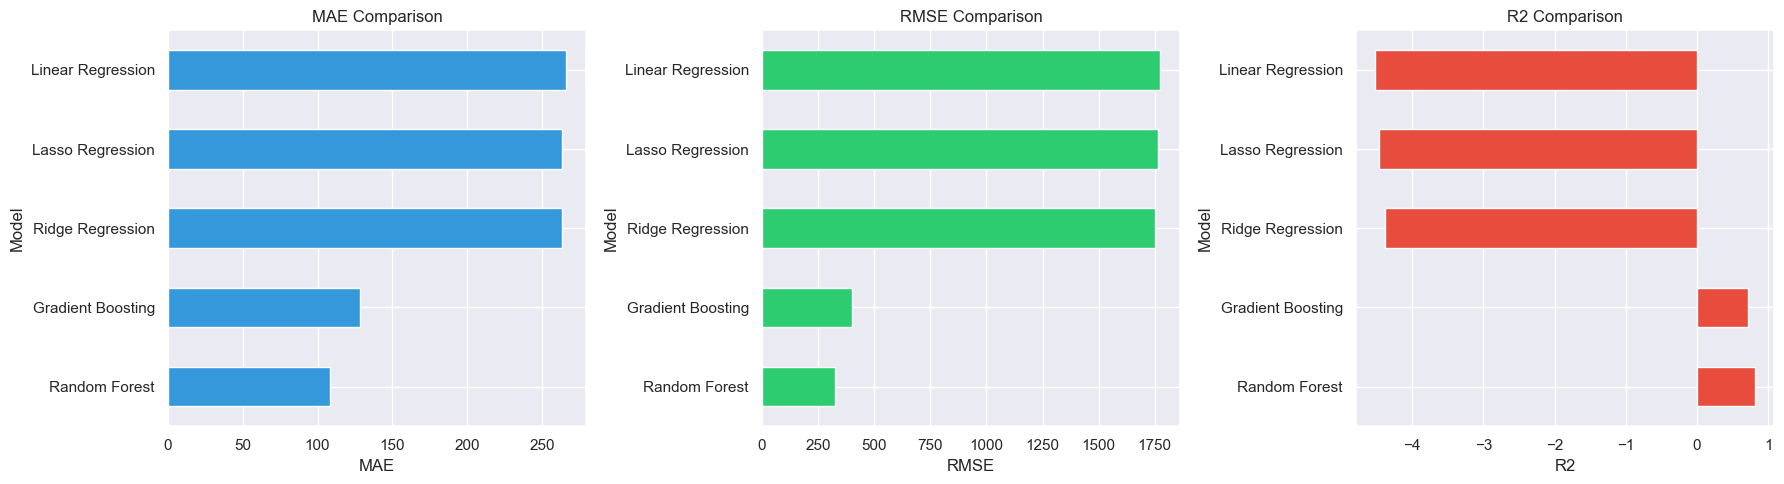

In [125]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Plot evaluation metrics (3 plots only)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Single row with 3 plots
metrics = ['MAE', 'RMSE', 'R2']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, metric in enumerate(metrics):
    results_df.sort_values(by=metric, ascending=(metric != 'R2')).plot(
        x='Model', y=metric, kind='barh', ax=axes[i], legend=False, color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Model')
    axes[i].grid(True)

# Display results table
display(results_df.drop(columns='Best Params'))
plt.tight_layout()
plt.show()

Model Performance Overview:

1. ***Linear, Ridge, and Lasso Regression***
* R²: -4.52 (Linear), -4.38 (Ridge), -4.47 (Lasso)

    These models perform poorly, with negative R² values indicating they do not explain the variance in the target variable at all.

* MAE: ~263
* MSE: ~3.1M
* RMSE: ~1,751

    Errors are quite high, showing that these linear models do not capture the underlying patterns in the data effectively. Ridge and Lasso offer only slight improvements over Linear Regression due to regularization.

2. ***Random Forest Regressor***
* R²: 0.8163

    A significant improvement, as it explains 82% of the variance in the target variable.

* MAE: 108.18
* MSE: 104,639.94
* RMSE: 323.48

    This model has much lower errors compared to the linear models, demonstrating that it captures the non-linear relationships in the data more effectively.

3. ***Gradient Boosting Regressor***
* R²: 0.7168
* MAE: 128.33
* MSE: 161,335.47
* RMSE: 401.67

    While it performs slightly worse than Random Forest, it still shows good predictive power. 